In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np
loans = pd.read_csv("kiva_loans.csv")
loans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector              671205 non-null  object 
 5   use                 666973 non-null  object 
 6   country_code        671197 non-null  object 
 7   country             671205 non-null  object 
 8   region              614405 non-null  object 
 9   currency            671205 non-null  object 
 10  partner_id          657698 non-null  float64
 11  posted_time         671205 non-null  object 
 12  disbursed_time      668809 non-null  object 
 13  funded_time         622874 non-null  object 
 14  term_in_months      671205 non-null  float64
 15  lender_count        671205 non-nul

The dataset covers Kiva loans primarily from 2016–2017. While not fully up to date, it remains valuable for demonstrating microfinance lending patterns and serves as a proxy for exploring financial inclusion challenges.

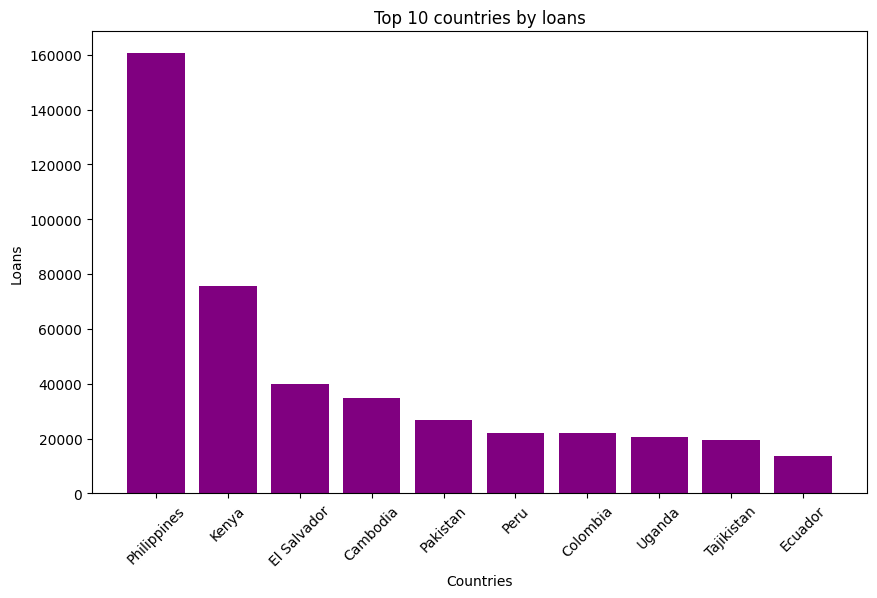

In [76]:
loan_country = loans[['country_code', 'country']]
val = loan_country['country'].to_list()
map1 = {}

for v in val:
    if v in map1:
        map1[v]+= 1
    else:
        map1[v] = 1
map2 = sorted(map1.items(), key = lambda x:x[1], reverse=True)
list1 = []
count = 0
for m in map2:
    if count < 10:
        list1.append(m)
    else:
        break
    count+=1

top_10 = pd.DataFrame(list1, columns=['Country', 'Loans'])
top_10["Country"]
plt.figure(figsize=(10,6))
plt.bar(top_10["Country"], top_10['Loans'], color="purple")
plt.title("Top 10 countries by loans")
plt.xlabel("Countries")
plt.ylabel("Loans")
plt.xticks(rotation=45)
plt.show()



Insights from this data:  
The Philippines leads by a wide margin in microfinance loans, followed by Kenya. Together, these two countries represent a substantial share of global loans, while most other countries receive far fewer. This indicates geographic concentration of lending activity, suggesting Kiva’s reach is strong in a few regions but has room to expand to underserved areas.

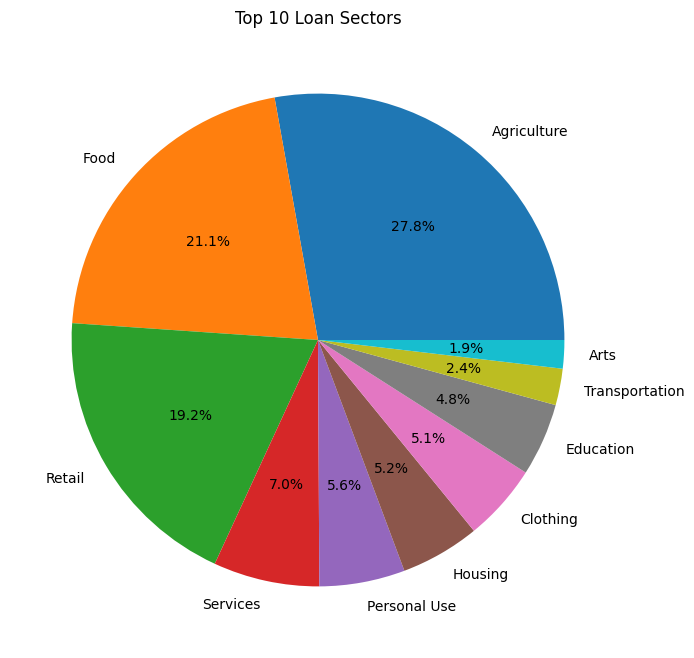

In [77]:
loan_sector = loans[['sector']].dropna()
sector_counts = loan_sector['sector'].value_counts().head(10)


plt.figure(figsize=(8,8))
plt.pie(
    sector_counts.values, 
    labels=sector_counts.index, 
    autopct='%1.1f%%'
   
)
plt.title("Top 10 Loan Sectors")
plt.show()





Data Insight:
Agriculture, food and retail absorb the majority of microfinance loans, indicating that lending is strongly geared towards essential consumption and small business activities. Sectors such as education and arts receive minimal funding, which may highlight gaps in support for long-term capacity building and community development

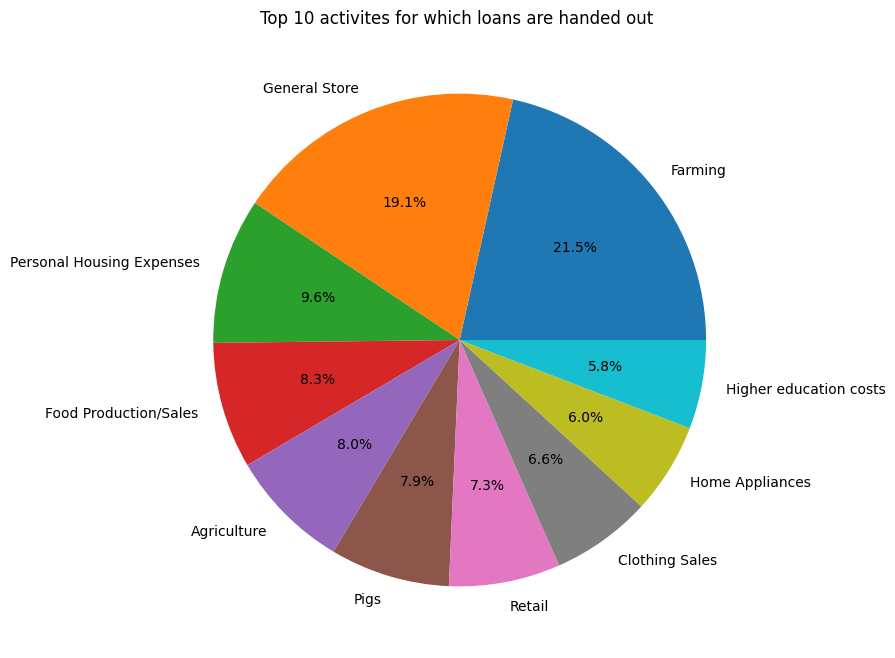

In [78]:
loan_activity = loans[['activity']].dropna()
activity_counts = loan_activity['activity'].value_counts().head(10)


plt.figure(figsize=(8,8))
plt.pie(
    activity_counts.values, 
    labels=activity_counts.index, 
    autopct='%1.1f%%'
   
)
plt.title("Top 10 activites for which loans are handed out ")
plt.show()

Data Insight:
The majority of loans are concentrated in farming and general store activities, which account for more than 40% of total microfinance lending. This distribution highlights microfinance’s role in sustaining livelihoods through agriculture and small trade. However, the presence of loans for education, housing and household items suggests that microfinance also plays an important role in supporting long-term well-being beyond business activities

In [79]:
sector_loan_stats = (
    loans
    .groupby("sector")["loan_amount"]
    .agg(["mean", "median"])
    .sort_values("mean", ascending=False)
)
sector_loan_stats.head()

,mean,median
sector,,
Entertainment,1673.674699,887.5
Wholesale,1569.716088,950.0
Clothing,1139.237829,600.0
Construction,1068.147735,700.0
Health,1067.266616,725.0


In [80]:
sector_loan_stats = (
    loans
    .groupby("country")["loan_amount"]
    .agg(["mean", "median"])
    .sort_values("mean", ascending=False)
)
sector_loan_stats.head()

,mean,median
country,,
Cote D'Ivoire,50000.0,50000.0
Mauritania,15000.0,15000.0
Chile,12265.0,5687.5
Bhutan,10000.0,10000.0
Afghanistan,7000.0,7000.0


**Disclaimer**:
Loan amounts in this dataset are reported in local currencies. As such, average loan sizes across sectors and countries are not directly comparable because differences may partly reflect currency exchange effects rather than actual differences in lending size. These results should therefore be interpreted as indicative patterns rather than precise cross-country comparisons. Calculations will be redone by converting all currencies to USD

Fully Funded    622877
Underfunded      48328
Name: funding_status, dtype: int64


([<matplotlib.patches.Wedge at 0x31dc56050>,
 [Text(-1.0719781073051273, 0.24670414965808224, 'Fully Funded'),
  Text(1.071978084207013, -0.24670425002391508, 'Underfunded')],
 [Text(-0.5847153312573421, 0.1345658998134994, '92.8%'),
  Text(0.5847153186583707, -0.13456595455849912, '7.2%')])

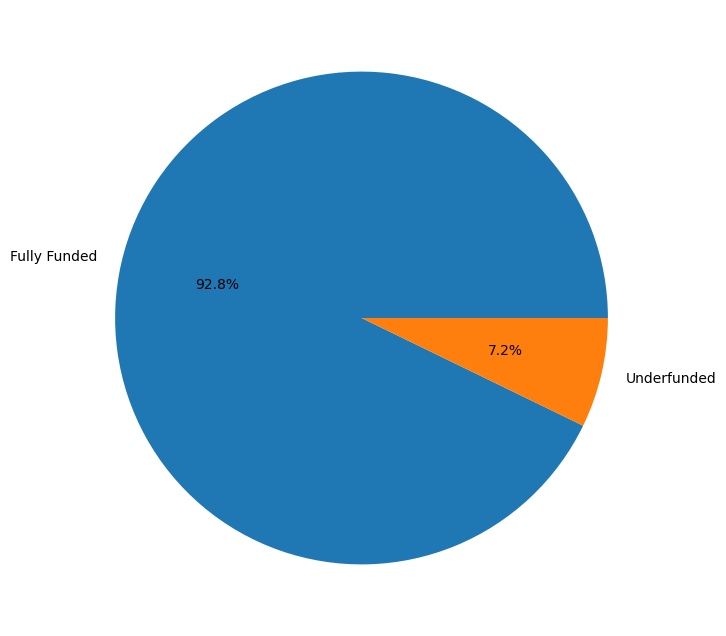

In [81]:
funding = loans[['funded_amount']].dropna()
loan_amt = loans[['loan_amount']].dropna()

loans["funding_status"] = np.where(loans['funded_amount'] < loans['loan_amount'], 'Underfunded', 'Fully Funded')
val = loans['funding_status'].value_counts()
print(val)
plt.figure(figsize=(8,8))
plt.pie(val.values, labels = val.index, autopct="%1.1f%%")


Insight:
The analysis shows that 92.8% of loans were fully funded, while 7.2% remained underfunded. This reflects the strong reliability of Kiva’s crowdfunding model, but also highlights the existence of unmet borrower needs

([<matplotlib.patches.Wedge at 0x31ca96b60>,
 [Text(0.825701879573999, 0.7267849792531251, 'El Salvador'),
  Text(-0.4508894598772497, 1.003343757129929, 'Kenya'),
  Text(-1.0782887850558214, 0.2174702187032537, 'Colombia'),
  Text(-0.9722019183924399, -0.5146099784050636, 'Philippines'),
  Text(-0.5849599691583656, -0.9315695542911674, 'Uganda'),
  Text(-0.11126376212027098, -1.0943584308803236, 'United States'),
  Text(0.3541396289970616, -1.0414341665097337, 'Tajikistan'),
  Text(0.7337584024547417, -0.8195111999399799, 'Pakistan'),
  Text(0.9851710362675212, -0.4893240534651639, 'Armenia'),
  Text(1.0894726670730859, -0.15181998452330767, 'Cambodia')],
 [Text(0.45038284340399937, 0.3964281705017046, '23.0%'),
  Text(-0.24593970538759072, 0.5472784129799613, '17.5%'),
  Text(-0.588157519121357, 0.11862011929268382, '12.7%'),
  Text(-0.5302919554867853, -0.2806963518573074, '9.1%'),
  Text(-0.3190690740863812, -0.5081288477951822, '7.6%'),
  Text(-0.060689324792875074, -0.59692278048

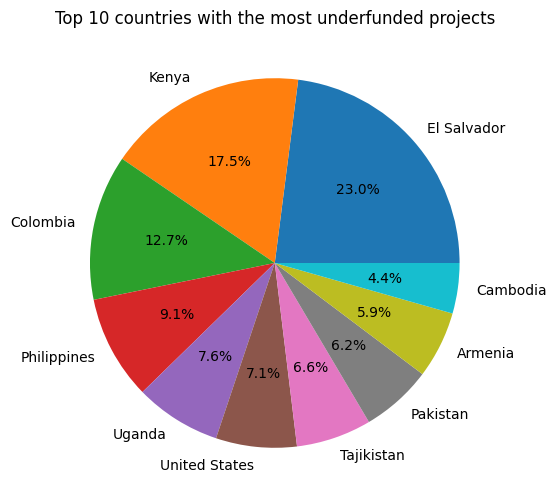

In [82]:
under = loans[loans["funding_status"] == "Underfunded"]
under_con = under["country"].value_counts().head(10)
under_sec = under["sector"].value_counts().head(10)
plt.figure(figsize=(10,6))
plt.title("Top 10 countries with the most underfunded projects")
plt.pie(under_con.values, labels = under_con.index, autopct="%1.1f%%")


Insight:
Underfunding is geographically concentrated, with El Salvador and Kenya together accounting for over 40% of cases. While microfinance often targets low-income countries, the presence of the United States in this list suggests that unmet funding needs also exist in developed markets. This highlights the importance of tailoring funding efforts by country.

([<matplotlib.patches.Wedge at 0x3066b1ae0>,
 [Text(0.674718884170128, 0.8687660371723894, 'Agriculture'),
  Text(-0.8807109544678676, 0.6590509955081608, 'Retail'),
  Text(-0.9268419861006858, -0.5924220900683367, 'Food'),
  Text(-0.2238572477521645, -1.0769809341993135, 'Housing'),
  Text(0.3418091413508514, -1.0455460348014303, 'Services'),
  Text(0.7655746608053223, -0.7898705202327885, 'Clothing'),
  Text(0.9704477755676749, -0.5179103348029963, 'Transportation'),
  Text(1.0571269927693767, -0.3041093901187108, 'Personal Use'),
  Text(1.0903818063695236, -0.14514653402108738, 'Education'),
  Text(1.0990977157587922, -0.04454448578449739, 'Health')],
 [Text(0.36802848227461527, 0.47387238391221237, '29.0%'),
  Text(-0.48038779334610954, 0.3594823611862695, '21.6%'),
  Text(-0.5055501742367376, -0.3231393218554563, '17.0%'),
  Text(-0.12210395331936244, -0.5874441459268982, '8.4%'),
  Text(0.1864413498277371, -0.5702978371644165, '8.2%'),
  Text(0.4175861786210849, -0.43083846558152

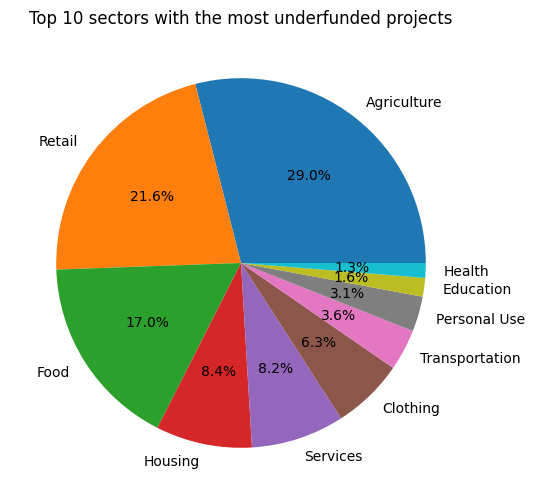

In [83]:
plt.figure(figsize=(10,6))
plt.title("Top 10 sectors with the most underfunded projects")
plt.pie(under_sec.values, labels = under_sec.index, autopct="%1.1f%%")

Insight:
Underfunding is most severe in agriculture and retail. This suggests that while demand for microfinance in these areas is very high, lender contributions do not always keep pace. Addressing gaps in these sectors could directly improve financial stability and income generation for borrowers

In [88]:
loans["funding_success"] = (loans["funded_amount"] >= loans["loan_amount"]).astype(int) 
y = loans["funding_success"]
X = loans[['loan_amount', 'sector', 'country', 'activity']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42,  stratify=y)
num_cols = ['loan_amount']
cat_cols = ['sector','country','activity']
data = ColumnTransformer(transformers=[("num", StandardScaler(), num_cols),("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)])
logis = Pipeline([("data", data), ("cato", LogisticRegression(max_iter=200, class_weight="balanced"))])

#So we do class weight as balanced because this makes the data to concentrate more on the minority otherwise the model will always produce
#fully funded it works on this:
# Formula for class weights when class_weight="balanced":
#
#     w_j = n_samples / (n_classes * n_j)
#
# Where:
#   w_j        = weight for class j
#   n_j        = number of samples in class j
#   n_samples  = total number of samples
#   n_classes  = total number of classes
#
# Meaning:
#   - Minority classes (small n_j) get higher weights.
#   - Majority classes (large n_j) get lower weights.


# **Reminder**
# Logistic Regression (for binary classification)
#
# Step 1: Linear combination of features
#   z = w0 + w1*x1 + w2*x2 + ... + wn*xn
#
# Step 2: Apply sigmoid function to squash z into probability
#   p = 1 / (1 + e^(-z))
#
# Step 3: Decision rule
#   if p >= 0.5 → predict class 1 (e.g. Fully Funded)
#   if p < 0.5  → predict class 0 (e.g. Underfunded)
#
# Notes:
#   - The model learns weights (w1, w2, ..., wn) during training.
#   - Positive weights increase probability of class 1.
#   - Negative weights decrease probability of class 1.
#   - Coefficients are interpretable → they show which features 
#     make loans more/less likely to be funded.

logis.fit(X_train,y_train)
y_pred = logis.predict(X_test)
print(classification_report(y_test,y_pred,digits=3))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0      0.155     0.764     0.258      9666
           1      0.974     0.677     0.798    124575

    accuracy                          0.683    134241
   macro avg      0.564     0.720     0.528    134241
weighted avg      0.915     0.683     0.759    134241



In [90]:
forest = Pipeline([("data",data),("random_forest_classifier", RandomForestClassifier(n_estimators=200,class_weight="balanced",random_state=42,n_jobs=-1))]
                  )

forest.fit(X_train,y_train)
y1_pred = forest.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.15      0.76      0.26      9666
           1       0.97      0.68      0.80    124575

    accuracy                           0.68    134241
   macro avg       0.56      0.72      0.53    134241
weighted avg       0.91      0.68      0.76    134241



Data Insight:

Both Logistic Regression and Random Forest models show consistent results. For underfunded loans (around 7% of the dataset), recall is high at about 76% but precision is very low at about 15%. This means the models successfully capture most underfunded cases but raise many false alarms by incorrectly labelling many fully funded loans as underfunded. For fully funded loans (around 93% of the dataset), precision is very high at about 97% with moderate recall at about 68%. This means predictions of “funded” are almost always correct, but some funded loans are misclassified as underfunded.

Overall performance shows that accuracy (about 68%) is misleading due to class imbalance, while the weighted F1 score (around 0.75) indicates reasonable performance, though the minority class remains the main challenge. Loan amount, country and sector strongly influence funding success, with underfunding concentrated in certain regions (such as El Salvador and Kenya) and industries (such as Agriculture and Retail).

**Final Result**:
**In conclusion, the models are reliable at flagging potentially underfunded loans (high recall) but they overestimate risk, which means they often misclassify safe, fully funded loans as risky underfunded ones. As a result, this model is well positoned to act as early warning systems to highlight loans at risk of underfunding, though further improvements such as senimenatal analysis of loan reason could reduce the number of false alarms.**